In [20]:
%pylab inline
import re
import pandas as pd
import numpy as np
import pickle

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [21]:
allSeqs = pd.read_pickle("/home/vxue/data/sort_specificity/relativeScores.pickle")
allSeqs = allSeqs[~allSeqs.protein.str.contains("\*")]
allSeqs = allSeqs[~allSeqs.protein.str.contains("X")]

In [22]:
myDataSets =[]
myDataSetName=[]

In [23]:
allSeqs.source.value_counts()

unknown    2989
m_b        1854
f_p        1588
m_p        1503
f_b        1194
x_p        1128
x_b         918
Name: source, dtype: int64

In [24]:
slopesDict = pickle.load(open("/home/vxue/data/lindsey_facs/slopes.pickle",'rb'))
slopesAndIntercepts = {'BFL1_100nM': slopesDict['BFL1_100nM'],
 'm1': slopesDict['m1'],
 'x1': slopesDict['x1'],
 'Bcl-xl_100nM': slopesDict['Bcl-xl_100nM'],
 'bfl1': slopesDict['bfl1'],
 'm1r': slopesDict['m1r'],
 'BCL-xl_1nM': slopesDict['BCL-xl_1nM'],
 'x100': slopesDict['x100']}


def getSlpInt(uniqueName):
    return slopesAndIntercepts[uniqueName]

In [25]:
uniqueNames = ['x1','BCL-xl_1nM',
               'BFL1_100nM','bfl1',
               'm1','m1r',
               'Bcl-xl_100nM','x100']
conc = [1,1,100,100,1,1,100,100]

In [26]:
def isOneHitWonder(row,uniqueName):
    
    myDistribution = list(row[[uniqueName+"_p"+str(each) for each in range(12)]].squeeze())
    
    maxPeak = np.argmax(myDistribution)
    
    
    #Edge cases
    if(maxPeak==0 and myDistribution[maxPeak+1]==0):
        return True
    elif(maxPeak==11 and myDistribution[maxPeak-1]==0):
        return True
        
    
    #One hits wonders
    if((myDistribution[maxPeak-1]==0) and (myDistribution[maxPeak+1]==0)):
        return True
    else:
        return False

In [27]:
for each,c in zip(uniqueNames,conc):
    slope,intercept = getSlpInt(each)
    #Eventually replace this with a linear function
    allSeqs[each+"_energy"] = allSeqs.apply(lambda x: x[each+"_expectedValue"] * slope+intercept,axis=1)
    allSeqs[each+"_ohw"] = allSeqs.apply(lambda x: isOneHitWonder(x,each),axis=1)

In [28]:
isDesigned = allSeqs.source.str.contains('x_b|x_p|m_b|m_p|f_b|f_p')

In [29]:
for score,shortName,unimodalBool,ohw in zip(
                          [k+"_energy" for k in uniqueNames],
                          ['x','s','f','t','m','n','z','c'],
                          [k+"_isUnimodal" for k in uniqueNames],
                          [k+"_ohw" for k in uniqueNames]
                          ):
    
    conditions = (~(allSeqs[score].isnull()) & (isDesigned)) & (allSeqs[unimodalBool]) & (allSeqs[ohw])
    print(len(allSeqs[conditions]))


27
19
84
317
25
33
93
47


In [30]:
for score,shortName,unimodalBool,ohw in zip(
                          [k+"_energy" for k in uniqueNames],
                          ['x','s','f','t','m','n','z','c'],
                          [k+"_isUnimodal" for k in uniqueNames],
                          [k+"_ohw" for k in uniqueNames]
                          ):
    
    conditions = (~(allSeqs[score].isnull()) & (isDesigned)) & (allSeqs[unimodalBool]) & ~(allSeqs[ohw])
    print(len(allSeqs[conditions]))

    f = allSeqs[conditions].copy()
    f['yValue'] = f[score]
    f['twentytwo'] = f.protein
    myDataSets.append(f.reset_index())
    myDataSetName.append("all_"+shortName)

2794
3556
1302
3484
3479
3628
1053
2894


In [31]:
for i in range(4):
    part1 = myDataSets[i*2] 
    part2 = myDataSets[i*2+1]
    combo = pd.concat([part1,part2])
    
    myDataSets.append(combo.reset_index())
    myDataSetName.append('combo'+myDataSetName[i*2])

In [32]:
[j for j in zip(myDataSetName,[len(i) for i in myDataSets],[sum(np.isnan(i.yValue)) for i in myDataSets])]

[('all_x', 2794, 0),
 ('all_s', 3556, 0),
 ('all_f', 1302, 0),
 ('all_t', 3484, 0),
 ('all_m', 3479, 0),
 ('all_n', 3628, 0),
 ('all_z', 1053, 0),
 ('all_c', 2894, 0),
 ('comboall_x', 6350, 0),
 ('comboall_f', 4786, 0),
 ('comboall_m', 7107, 0),
 ('comboall_z', 3947, 0)]

In [33]:
pickle.dump([myDataSets,myDataSetName],open('/home/vxue/data/sort_specificity/ncv_y/allData.pickle','wb'))

In [34]:
[myDataSets_load,myDataSetName_load] = pickle.load(open('/home/vxue/data/sort_specificity/ncv_y/allData.pickle','rb'))

In [35]:
[j for j in zip(myDataSetName_load,[len(i) for i in myDataSets_load],[sum(np.isnan(i.yValue)) for i in myDataSets_load])]

[('all_x', 2794, 0),
 ('all_s', 3556, 0),
 ('all_f', 1302, 0),
 ('all_t', 3484, 0),
 ('all_m', 3479, 0),
 ('all_n', 3628, 0),
 ('all_z', 1053, 0),
 ('all_c', 2894, 0),
 ('comboall_x', 6350, 0),
 ('comboall_f', 4786, 0),
 ('comboall_m', 7107, 0),
 ('comboall_z', 3947, 0)]

In [36]:
myDataSetName

['all_x',
 'all_s',
 'all_f',
 'all_t',
 'all_m',
 'all_n',
 'all_z',
 'all_c',
 'comboall_x',
 'comboall_f',
 'comboall_m',
 'comboall_z']

In [37]:
len(myDataSetName)

12

all_x
all_s
all_f
all_t
all_m
all_n
all_z
all_c
comboall_x
comboall_f
comboall_m
comboall_z


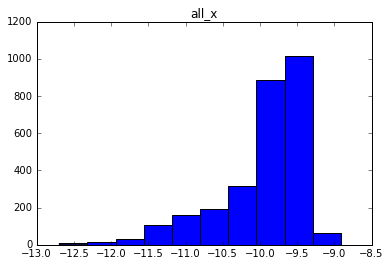

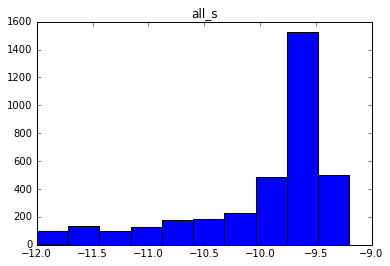

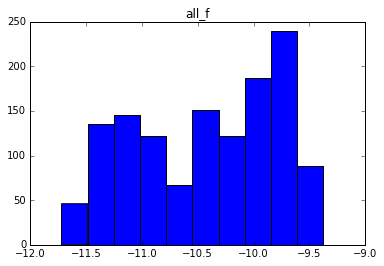

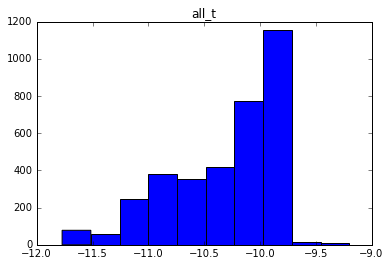

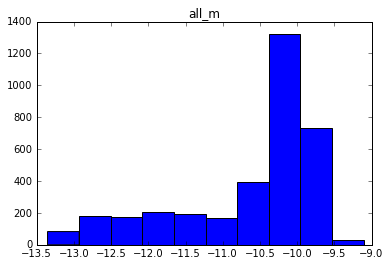

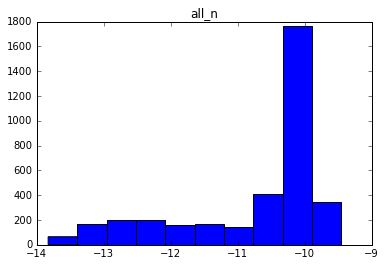

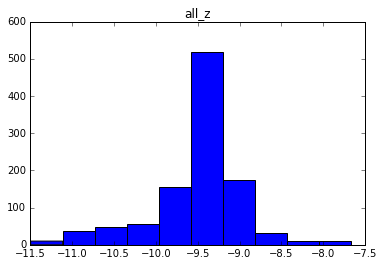

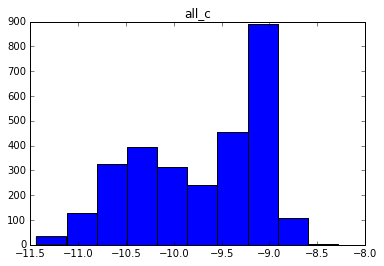

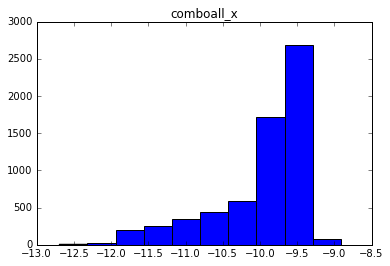

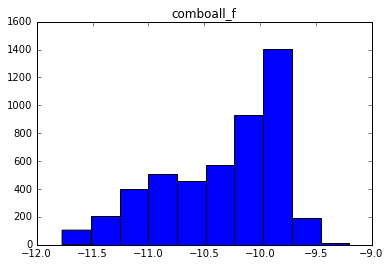

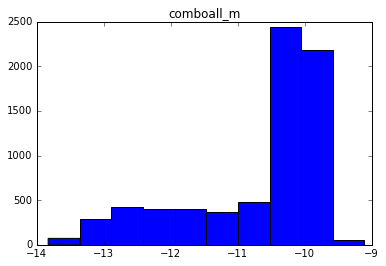

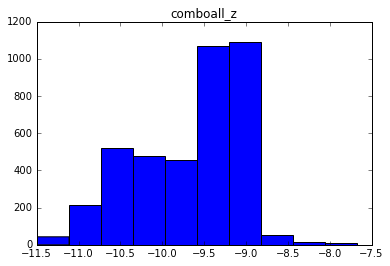

In [40]:
for each,ds in zip(myDataSetName,myDataSets):
    print(each)
    fig,ax = plt.subplots()
    hist(ds.yValue)
    title(each)